# MQTT - using `paho` Package

MQTT and MQTT-SN are IP protocols used to manage devices in the Internet of Things.  These protocols implement a publish and subscribe communication protocol between *clients*.  The publish and subscribe communication is managed by *brokers*.  One of the key ideas of MQTT and MQTT-SN is that brokers are relatively robust and available, while clients are often transient (for instance they might often sleep to save power).  Typically a client will publish *events* to a broker.  Each event consists of a *topic* and a *message*.   Typically the broker will relay each event to other clients who have subscribed to the same topic, although brokers may also communicate directly to relay events.  The main difference between MQTT and MQTT-SN is that MQTT is based on TCP, while MQTT-SN is based on UDP.  For more information, see http://mqtt.org/documentation.

The `paho` package is a readily available MQTT client. This notebook shows
a demo of using this package.

## 1. Start MQTT broker

First we need to start a MQTT broker in order for all the clients to connect.

In [1]:
from pynq_networking import Broker

broker_mqtt = Broker(mqtt_port=1883, mqttsn_port=1884)

When broker is open, users can connect to it; if there is already a broker
running, the following method will close it before opening a new one.

Users can also check the log file in `broker.log`.

In [2]:
broker_mqtt.open()

## 2. Use `paho` package to connect
We can use this package to publish and subscribe to events.

In [3]:
import paho.mqtt.client as mqtt

client = mqtt.Client()
def on_subscribe(client, userdata, mid, granted_qos):
    print("Subscription Succeeded!")
def on_connect(client, userdata, flags, rc):
    print("Connection Succeeded!")
def on_publish(client, userdata, mid):
    print("Publish Succeeded!")

client.on_subscribe = on_subscribe
client.on_connect = on_connect

Connect to the local host and wait for an acknowledgment.

In [4]:
client.connect("localhost", 1883)
for _ in range(10):
    client.loop(timeout=.1)

Connection Succeeded!


In the `paho` API, subscribing to an event is done by registering a callback function.
We can use the callback to take an action, such as flashing the LEDs on the board.

Notice that messages aren't actually processed until one of the `paho` event loop functions is called,
e.g., `loop()` or `loop_forever()`.

In [5]:
from pynq.overlays.base import BaseOverlay

overlay = BaseOverlay('base.bit')

leds = overlay.leds
btns = overlay.buttons

return_message = ""
def on_message(client, userdata, message):
    print("Received message '" + str(message.payload) + 
          "' on topic '" + message.topic + "' with QoS " + str(message.qos))
    for led in leds:
        led.toggle()

client.on_message = on_message

We can subscribe to a new topic now. The function returns a tuple 
(`result`, `mid`), where result is `MQTT_ERR_SUCCESS` to indicate success 
or (`MQTT_ERR_NO_CONN`, `None`) if the client is not currently connected. 
`mid` is the message ID for the subscribe request. The `mid` value can be used 
to track the subscribe request by checking against the `mid` argument in the 
`on_subscribe()` callback if it is defined.  Note that the "#" symbol in the
subscription is interpreted as a wildcard. This matches "button/0" and
"button/1" for example.

More information can be found at: 
https://www.eclipse.org/paho/clients/python/docs/#subscribe-unsubscribe

Subscribe to a topic and wait for an acknowledgment.

In [6]:
client.subscribe("button/#")
for _ in range(10):
    client.loop(timeout=.1)

Subscription Succeeded!


Publishing an event is somewhat simpler, we simply need to provide the topic and the message.

The next cell continually reads the current state of the buttons and publishes some 
corresponding MQTT messages.
In addition, regularly call the `loop()` function to process MQTT messages 
that are subscribed to.  

Button values are read until button 3 is pressed.

Note that the `while` loop is required to avoid `Broken pipe` error message.

In [7]:
last = [btns[index].read() for index in range(3)]

print("Waiting for button presses...")
while (btns[3].read()==0):
    current = [btns[index].read() for index in range(3)]
    changed = [current[index] != last[index] for index in range(3)]
    _ = [client.publish('button/' + str(index), str(current[index])) 
            if(changed[index]) else None for index in range(3)]
    last = current
    client.loop(timeout=.001)

print(current)
_ = [client.publish('button/'+str(index), "offline") for index in range(3)]

Waiting for button presses...
Received message 'b'1'' on topic 'button/0' with QoS 0
Received message 'b'0'' on topic 'button/0' with QoS 0
Received message 'b'1'' on topic 'button/1' with QoS 0
Received message 'b'0'' on topic 'button/1' with QoS 0
Received message 'b'1'' on topic 'button/2' with QoS 0
Received message 'b'0'' on topic 'button/2' with QoS 0
[0, 0, 0]


Note that publishing events with MQTT can be quite fast, if we don't guarantee that the events are received by the server.

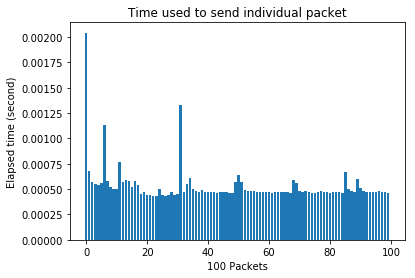

Average speed: 1892.6370230730513 packets/second.


In [8]:
import timeit
import matplotlib.pyplot as plt

num_records = 100
time_records = [0 for _ in range(num_records)]
total_time = 0

for i in range(num_records):
    start_time = timeit.default_timer()
    client.publish("foo", "bar")
    elapsed = timeit.default_timer() - start_time
    time_records[i] = elapsed
    total_time += elapsed

plt.bar(range(num_records), time_records, align='center')
plt.title("Time used to send individual packet")
plt.xlabel("100 Packets")
plt.ylabel("Elapsed time (second)")
plt.show()
print("Average speed: " + str(num_records/total_time)+" packets/second.")

## 3. Close the broker

It is always a good practice to close the broker after use. Otherwise it keeps
running in the background.

In [9]:
broker_mqtt.close()